In [1]:
from pathlib import Path

import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from wmfdata import charting, hive

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [2]:
%matplotlib inline
charting.set_mpl_style()

In [3]:
# UPDATE FOR NEW MONTH!
# Metric month. The mediawiki_history snapshot for this month must be available.
# METRICS_MONTH_TEXT = "2019-07"
# MEDIAWIKI_HISTORY_SNAPSHOT = "2019-07"

last_month = datetime.date.today().replace(day=1) - datetime.timedelta(days=1)
first_day_month = last_month.replace(day=1)

METRICS_MONTH_TEXT = last_month.strftime("%Y-%m")
MEDIAWIKI_HISTORY_SNAPSHOT = last_month.strftime("%Y-%m")

metrics_month = pd.Period(METRICS_MONTH_TEXT)
insert_start = str(metrics_month)
insert_end = str(metrics_month + 1)
graph_start = str(metrics_month - 48)

# Update table

In [4]:
create_cmd = Path("queries/mobile_create_editor_month.sql").read_text()
update_cmd = Path("queries/update_editor_month_mobile.sql").read_text().format(
    start=insert_start,
    end=insert_end,
    mwh_snapshot=MEDIAWIKI_HISTORY_SNAPSHOT
)

In [5]:

# check latest date before updating the table
max_month = hive.run("""
select
    max(month) as max
from cchen.editor_month 
limit 1000
""")

if max_month.loc[0,max] < first_day_month:
    hive.run(update_cmd)

In [6]:
max_month.loc[0,max]

Timestamp('2019-12-01 00:00:00')

# Quality checks

In [7]:
editors = hive.run("""
select
    month,
    count(*) as editors,
    sum(cast(content_edits >= 5 as int)) as active_editors,
    sum(cast(content_edits >= 100 as int)) as very_active_editors
from cchen.editor_month 
group by month
order by month asc
limit 1000
""")

editors = (
    editors
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
)

editors.tail()

,editors,active_editors,very_active_editors
month,,,
2019-09-01,385202,105392,16360
2019-10-01,402572,107495,16494
2019-11-01,401671,107886,16095
2019-12-01,391477,107123,16039
2020-01-01,425698,113250,17249


In [8]:
editors_per_wiki = hive.run("""
select
    month,
    wiki,
    count(*) as editors 
from cchen.editor_month 
where
    wiki in ("arwiki", "dewiki", "enwiki", "kowiki", "zhwiki")
group by month, wiki
order by month, wiki
limit 10000
""")

editors_per_wiki = (
    editors_per_wiki
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
    .pivot(columns="wiki")
    .xs("editors", axis=1)
)

editors_per_wiki.tail()

wiki,arwiki,dewiki,enwiki,kowiki,zhwiki
month,,,,,
2019-09-01,5349,18886,132818,2077,8266
2019-10-01,5345,19944,141797,2225,8433
2019-11-01,5699,20087,139611,2332,8192
2019-12-01,5861,19134,132370,2298,8203
2020-01-01,5466,21932,143200,2502,8391


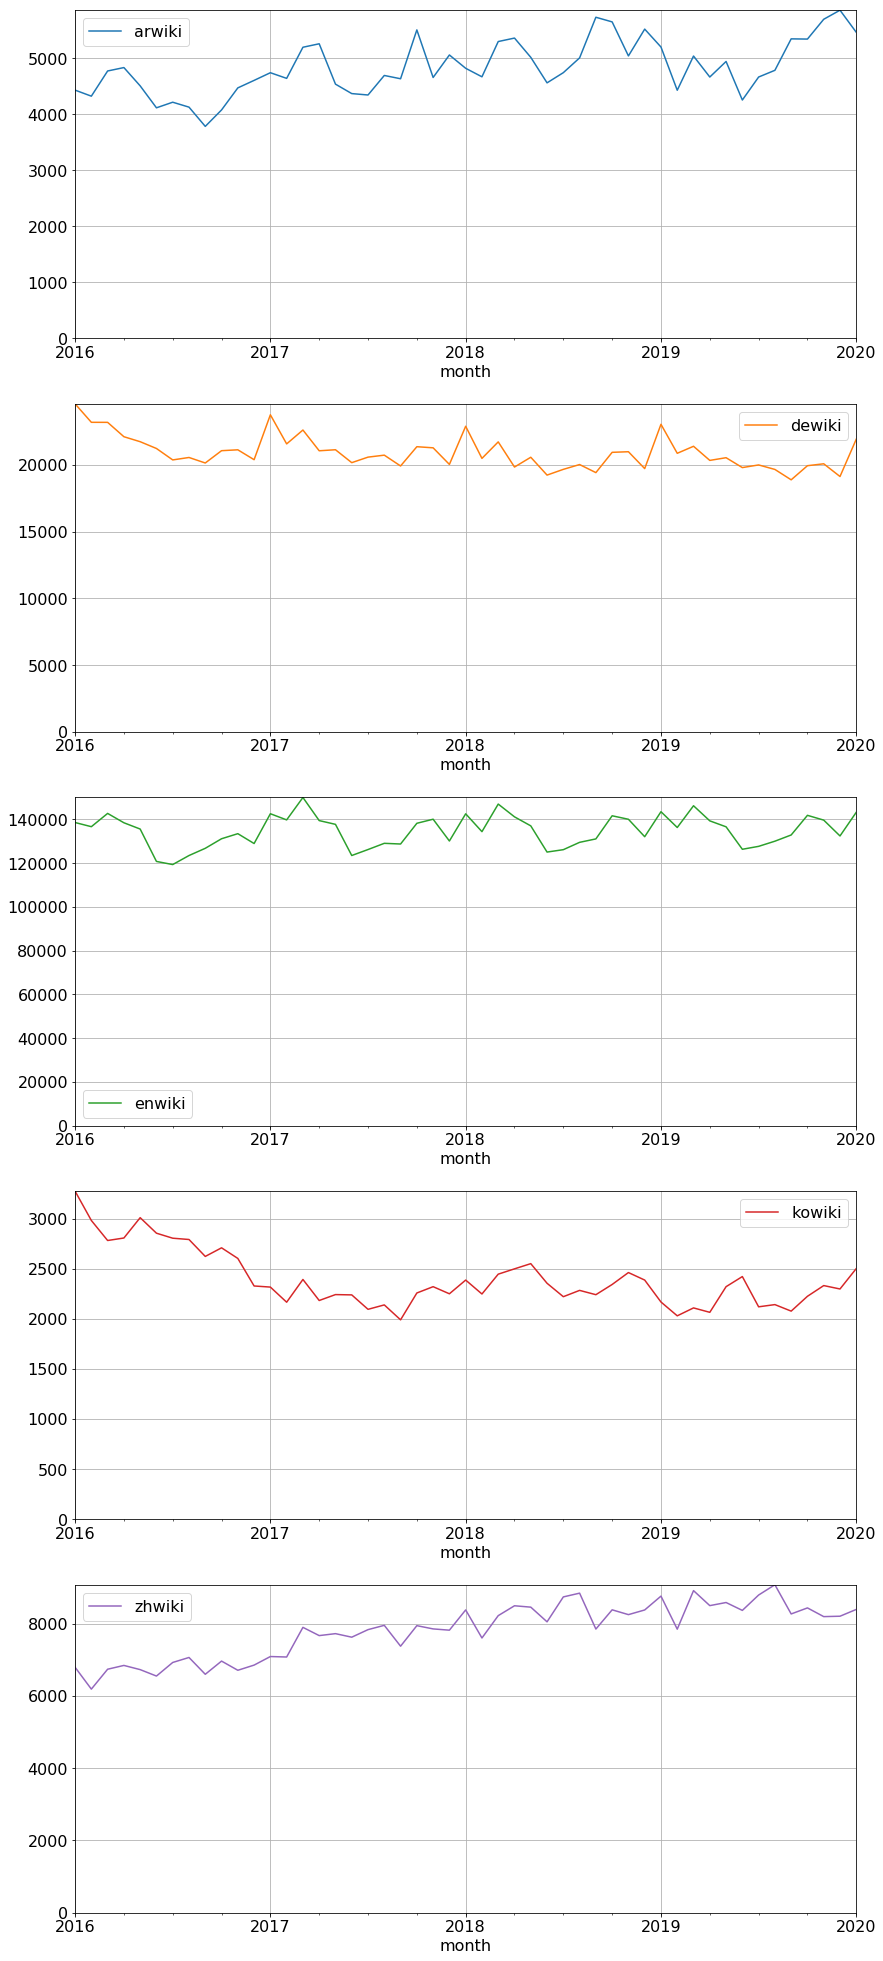

In [9]:
editors_per_wiki[graph_start:].plot(
    ylim=0,
    subplots=True,
    figsize=(14, 35),
    sharex=False
);